In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import constants as cnst, u_darrays as uda
import salem
import xarray as xr
import ipdb
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [121]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-50_allClouds_monthly.nc'
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -7]

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
# This masks out the data which is not in the region

da3 = da3.salem.roi(shape=sdf).mean(['lat', 'lon'])*100
ca = ca.salem.roi(shape=sdf).mean(['latitude', 'longitude'])
tag = 'RioSanta'

In [44]:
#mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_-40_allClouds_monthly.nc'
mcs = cnst.GRIDSAT_PERU + 'aggs/gridsat_WA_count_-50_allClouds_monthly.nc'
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -7]

topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))


da3 = xr.open_dataarray(mcs).sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))
ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
# This masks out the data which is not in the region

topo_on_da3 = da3.salem.lookup_transform(topo)
da3 = da3.where(topo_on_da3>3000)

topo_on_ca = ca.salem.lookup_transform(topo)
ca = ca.where(topo_on_ca>3000)
tag='TropicalAndes'

In [122]:
ca[0,:,:].plot()

IndexError: too many indices

In [46]:
da3 = da3.mean(['lat', 'lon'])*100
ca = ca.mean(['latitude', 'longitude'])

In [47]:
year_season = xr.DataArray(da3.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[da3.time], name='year_season')

In [48]:
year_season

<xarray.DataArray 'year_season' (time: 396)>
array(['1985-02-28T23:59:59.999999999', '1985-02-28T23:59:59.999999999',
       '1985-05-31T23:59:59.999999999', ..., '2017-11-30T23:59:59.999999999',
       '2017-11-30T23:59:59.999999999', '2018-02-28T23:59:59.999999999'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2017-12-31

In [123]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

In [124]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [125]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-DEC').sum() /  month_length.where(ds.notnull()).resample(time='QS-DEC').sum())

    # Calculate the weighted average
    return result[result['time.month']==12]


In [126]:
gts = season_mean(da3)

In [127]:
cts = season_mean(ca)

In [128]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u200_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [129]:
era = readERA()
era = era.sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3]))
topo_on_era = era.salem.lookup_transform(topo)
era = era.where(topo_on_era>1000)

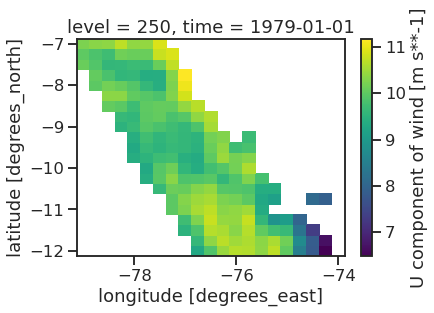

In [130]:
era['u'][0,:,:].plot()

In [131]:
era_valley = era['u'].mean(['latitude', 'longitude']) #salem.roi(shape=sdf)
ets = season_mean(era_valley)

In [132]:
ets

<xarray.DataArray (time: 41)>
array([-7.47489044e-01, -6.90303635e-03, -1.81280428e+00, -4.94119818e+00,
        6.43454197e+00, -6.77643635e+00, -4.58812734e+00, -5.24060714e+00,
       -1.72119220e+00,  9.65106455e-01, -5.37328105e+00,  4.08787103e+00,
       -5.33061415e+00,  7.80514840e+00,  2.01363402e+00, -6.22727911e+00,
       -2.70410234e+00, -4.91285932e+00, -5.49772022e+00, -5.86767974e+00,
       -7.87240427e+00, -7.76860109e+00, -4.71737109e+00, -4.29910118e-01,
       -3.54992777e+00, -5.08030963e+00, -1.53902626e+00, -6.34995182e+00,
       -5.53165547e+00, -7.38594633e+00, -5.92172711e+00, -3.28025371e+00,
       -1.05754596e+01, -2.79429294e+00, -7.04850395e-01, -5.77660441e+00,
       -1.93940304e+00,  5.34417492e+00, -6.54342144e+00, -4.83949326e+00,
       -2.63974930e+00])
Coordinates:
  * time     (time) datetime64[ns] 1978-12-01 1979-12-01 ... 2018-12-01
    level    int32 250

In [133]:
posgrid = np.intersect1d(ets.time, gts.time)

gsat = gts.sel(time=posgrid)
ets = ets.sel(time=posgrid)

posgrid = np.intersect1d(ets.time, cts.time)
cts = cts.sel(time=posgrid)

In [134]:
ets = ets.to_pandas()
gts = gts.to_pandas()
cts = cts.to_pandas()

In [135]:
ets.index

DatetimeIndex(['1984-12-01', '1985-12-01', '1986-12-01', '1987-12-01',
               '1988-12-01', '1989-12-01', '1990-12-01', '1991-12-01',
               '1992-12-01', '1993-12-01', '1994-12-01', '1995-12-01',
               '1996-12-01', '1997-12-01', '1998-12-01', '1999-12-01',
               '2000-12-01', '2001-12-01', '2002-12-01', '2003-12-01',
               '2004-12-01', '2005-12-01', '2006-12-01', '2007-12-01',
               '2008-12-01', '2009-12-01', '2010-12-01', '2011-12-01',
               '2012-12-01', '2013-12-01', '2014-12-01', '2015-12-01',
               '2016-12-01', '2017-12-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [136]:
ets

time
1984-12-01    -4.588127
1985-12-01    -5.240607
1986-12-01    -1.721192
1987-12-01     0.965106
1988-12-01    -5.373281
1989-12-01     4.087871
1990-12-01    -5.330614
1991-12-01     7.805148
1992-12-01     2.013634
1993-12-01    -6.227279
1994-12-01    -2.704102
1995-12-01    -4.912859
1996-12-01    -5.497720
1997-12-01    -5.867680
1998-12-01    -7.872404
1999-12-01    -7.768601
2000-12-01    -4.717371
2001-12-01    -0.429910
2002-12-01    -3.549928
2003-12-01    -5.080310
2004-12-01    -1.539026
2005-12-01    -6.349952
2006-12-01    -5.531655
2007-12-01    -7.385946
2008-12-01    -5.921727
2009-12-01    -3.280254
2010-12-01   -10.575460
2011-12-01    -2.794293
2012-12-01    -0.704850
2013-12-01    -5.776604
2014-12-01    -1.939403
2015-12-01     5.344175
2016-12-01    -6.543421
2017-12-01    -4.839493
dtype: float64

DatetimeIndex(['1994-12-01', '1995-12-01', '1996-12-01', '1997-12-01',
               '1998-12-01', '1999-12-01', '2000-12-01', '2001-12-01',
               '2002-12-01', '2003-12-01', '2004-12-01', '2005-12-01',
               '2006-12-01', '2007-12-01', '2008-12-01', '2009-12-01',
               '2010-12-01', '2011-12-01', '2012-12-01'],
              dtype='datetime64[ns]', name='time', freq=None) LinregressResult(slope=-0.5654734762773561, intercept=13.277455887338474, rvalue=-0.3722576231225456, pvalue=0.11653171532681399, stderr=0.3419422208625094)


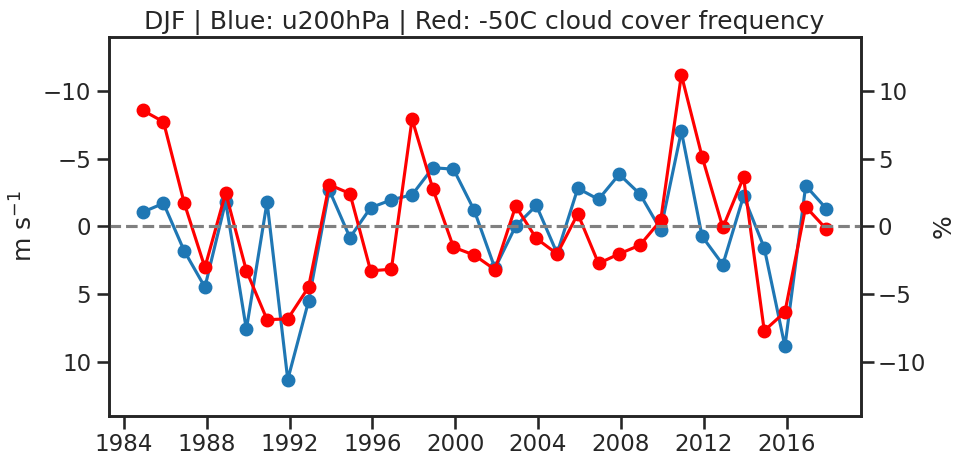

In [137]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot((ets-np.mean(ets)), marker='o', label='u200hPa')
ax1 = ax.twinx()
ax1.plot((gts-np.mean(gts)), color='r', marker='o', label='-50C cloud cover frequency')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: u200hPa | Red: -50C cloud cover frequency')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax1.set_ylabel('%')
ax.set_ylabel('m s$^{-1}$')
ax.set_ylim(-14,14)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-14,14)
plt.axhline(0, linestyle='dashed', color='grey')
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_GRIDSATvsU200_'+tag+'.jpg')

DatetimeIndex(['1994-12-01', '1995-12-01', '1996-12-01', '1997-12-01',
               '1998-12-01', '1999-12-01', '2000-12-01', '2001-12-01',
               '2002-12-01', '2003-12-01', '2004-12-01', '2005-12-01',
               '2006-12-01', '2007-12-01', '2008-12-01', '2009-12-01',
               '2010-12-01', '2011-12-01', '2012-12-01'],
              dtype='datetime64[ns]', name='time', freq=None) LinregressResult(slope=-0.5654734762773561, intercept=13.277455887338474, rvalue=-0.3722576231225456, pvalue=0.11653171532681399, stderr=0.3419422208625094)


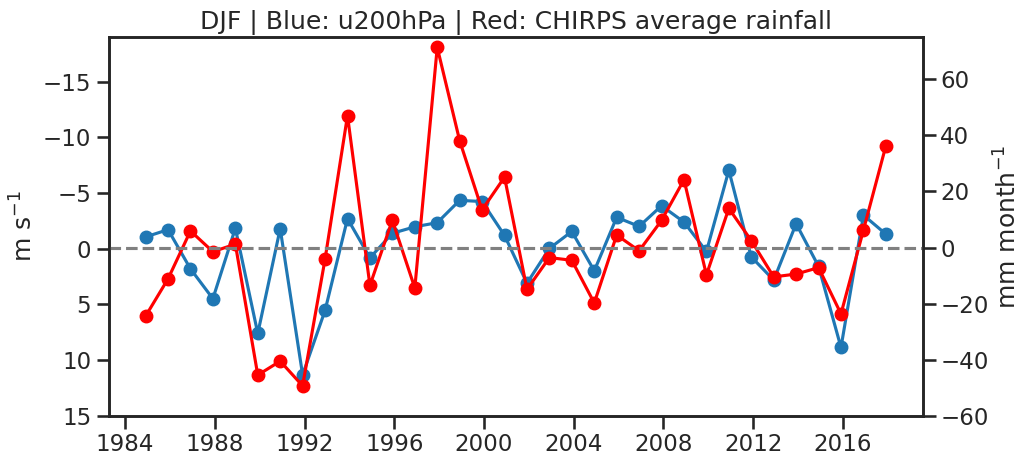

In [154]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
ax.plot((ets-np.mean(ets)), marker='o', label='u200hPa')
#ax.plot((ets-np.mean(ets)).rolling(center=True,window=10).mean()*-1, color='purple')
ax1 = ax.twinx()
ax1.plot((cts-np.mean(cts)), color='r', marker='o', label='CHIRPS average rainfall')
print(ets.index[10:-5],stats.linregress(ets.values[10:-5], gts.values[10:-5]))
plt.title('DJF | Blue: u200hPa | Red: CHIRPS average rainfall')

plt.axhline(0, linestyle='dashed', color='grey')
ax.set_ylim(-19,15)
ax.set_ylim(ax.get_ylim()[::-1])
ax1.set_ylim(-60,75)
plt.tight_layout()
ax1.set_ylabel('mm month$^{-1}$')
ax.set_ylabel('m s$^{-1}$')
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/interannual_timeseries_corr_CHIRPSvsU200_'+tag+'.jpg')

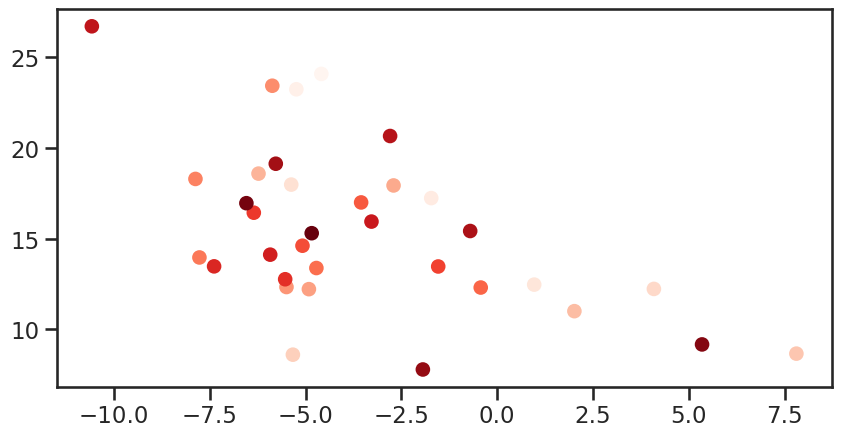

In [155]:
f=plt.figure(figsize=(10,5), dpi=100)
ax = f.add_subplot(111)
plt.scatter(ets,gts, c=ets.index, cmap='Reds')

### Trend analysis 

In [156]:
# the trend are computed on time series at least 20yrs long
start_years = ets.index[:-5]
start_years_p = start_years.year
end_years = ets.index[5:]
end_years_p = end_years.year
ny = len(start_years)
extent = (start_years_p[0], start_years_p[-1], end_years_p[0], end_years_p[-1])  # needed for the plot later

In [157]:
extent

(1984, 2012, 1989, 2017)

In [158]:
# fill the triangle
trend = np.zeros((ny, ny)) *np.nan
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = cts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

In [159]:
trend = np.array(trend)
sig = np.array(sig)

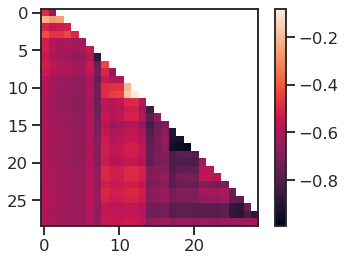

In [160]:
plt.imshow(trend)
plt.colorbar()

### Plot 

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


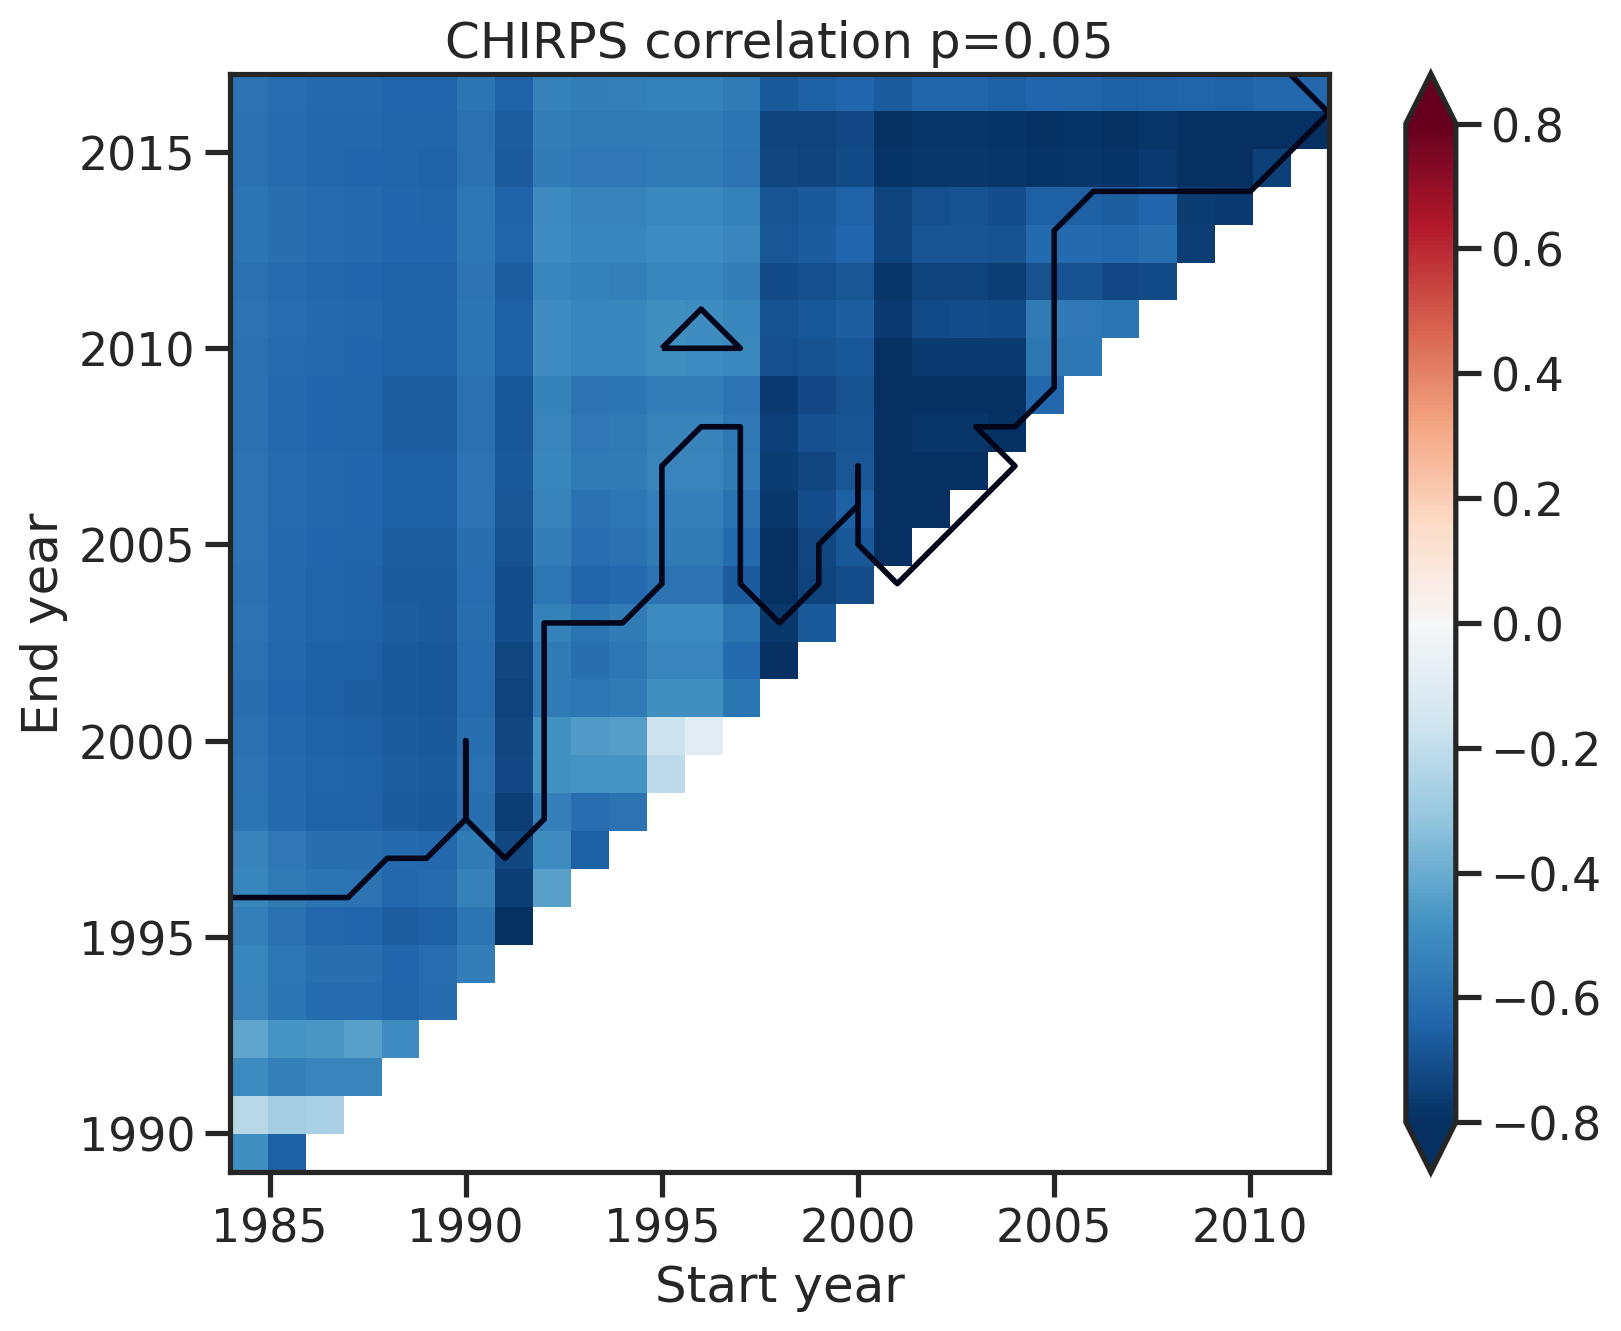

In [161]:
# plot
f= plt.figure(figsize=(9, 7),dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
# ax.set_xtick_labels(start_years_p)
# ax.set_ytick_labels(end_years_p)
plt.title('CHIRPS correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()

f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_CHIRPSvsU200_'+tag+'.jpg')

In [162]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data1 = ets.loc[start_year:end_year]
        data2 = gts.loc[start_year:end_year]
        if len(data1) < 5:
            continue
        slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
        trend[j, i] = r   # for decadal trends
        sig[j, i] = p_val

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


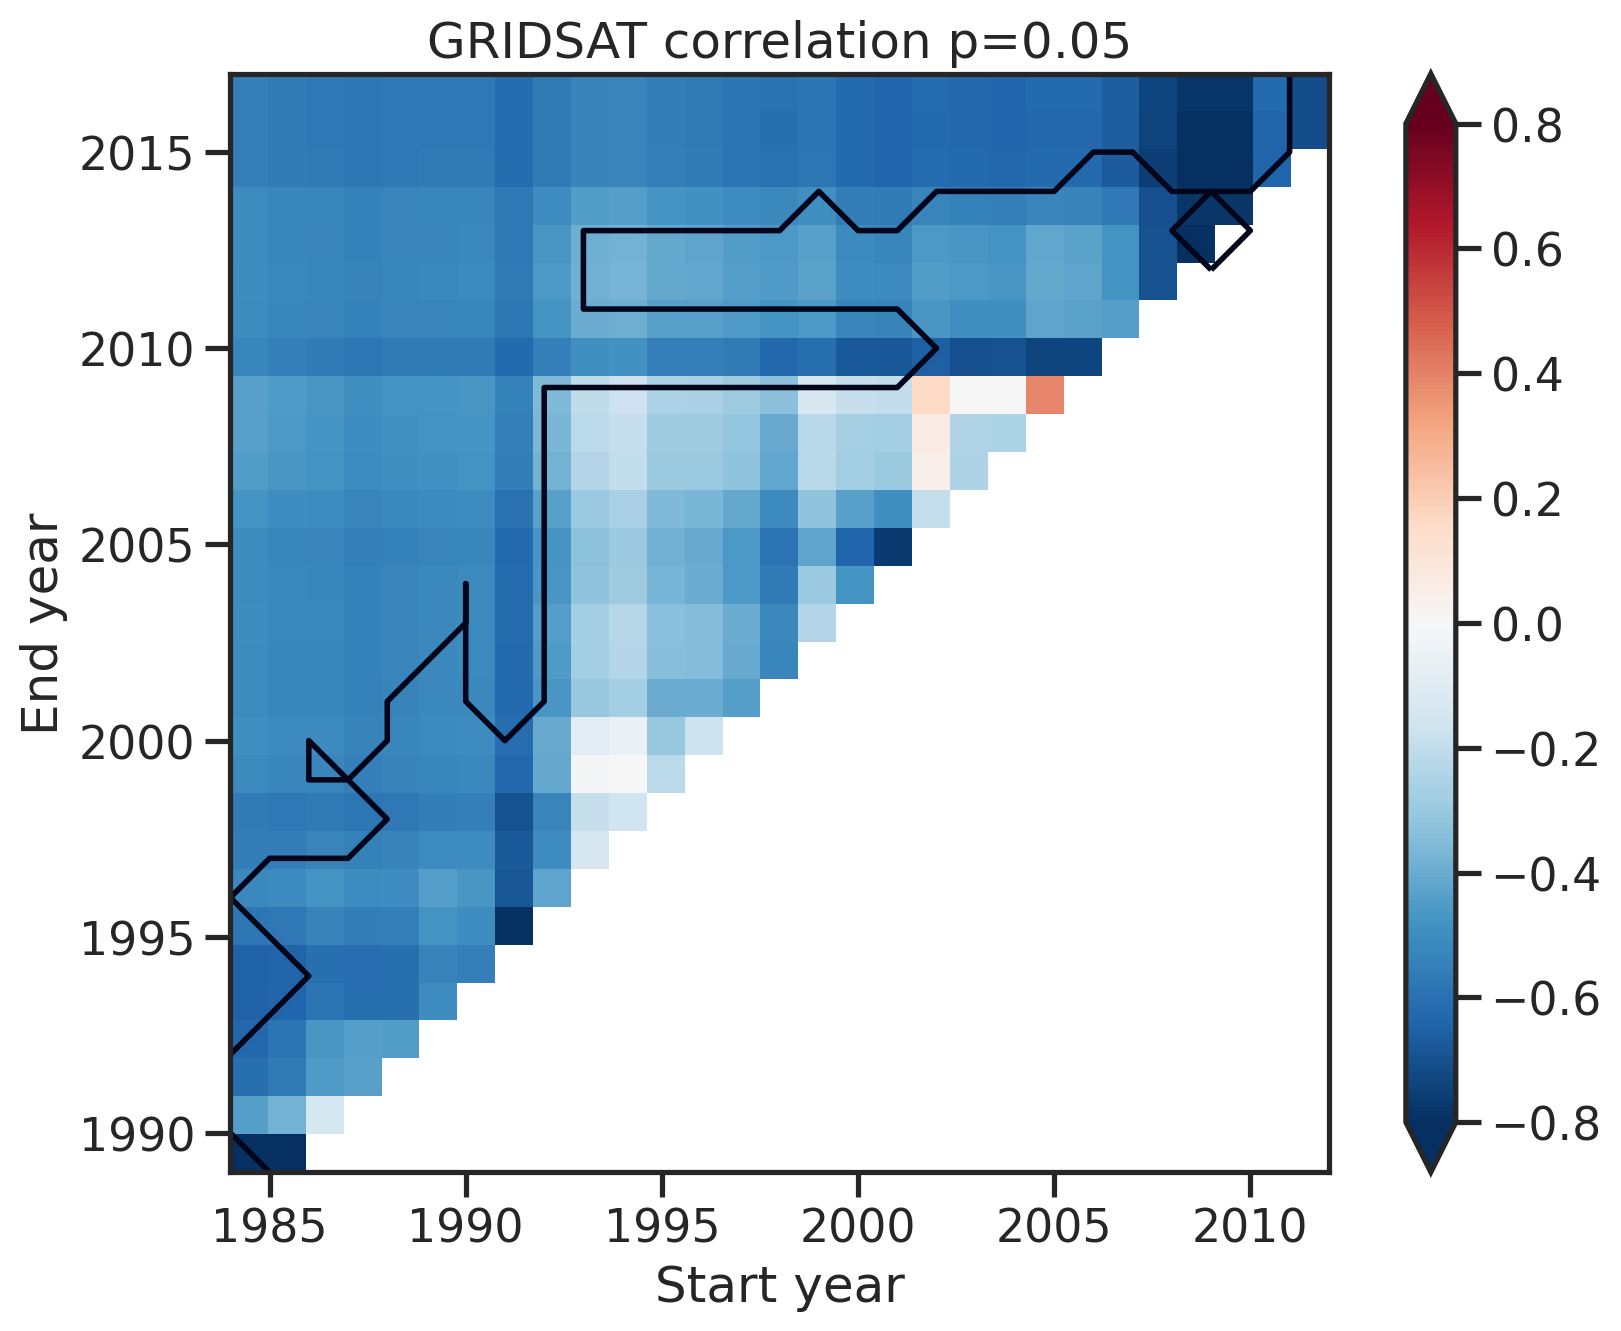

In [163]:
f= plt.figure(figsize=(9, 7), dpi=200)
ax = f.add_subplot(111)
im = plt.imshow(trend, cmap=cmap, vmin=-0.8, vmax=0.8, extent=extent, interpolation='none', origin='lower')  #, 
#im = plt.contourf(start_years, end_years, trend, linewidths=1, levels=np.arange(-0.8,0.81,0.1), cmap='RdBu_r')
plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=2, levels=[-1,0,1])
plt.colorbar(im, extend='both');
plt.title('GRIDSAT correlation p=0.05');
plt.xlabel('Start year');
plt.ylabel('End year');
plt.tight_layout()
#plt.savefig('triangle_giss.png', dpi=150)
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_DJF_GRIDSATvsU200_'+tag+'.jpg')

In [164]:
def monthly(m, d1,d2):

    dg = d1.sel(time=(d1['time.month']==m)).groupby('time.year').mean('time')
    de = d2.sel(time=(d2['time.month']==m)).groupby('time.year').mean('time')
                 
    posgrid = np.intersect1d(dg.year.values, de.year.values)

    de = de.sel(year=posgrid)
    dg = dg.sel(year=posgrid)
                 
    dg = dg.to_pandas()
    de = de.to_pandas()
                 
    # fill the triangle
    trend = np.zeros((ny, ny)) * np.NaN
    sig = np.ones((ny, ny)) 
    for i, start_year in enumerate(start_years_p):
        for j, end_year in enumerate(end_years_p):
            data1 = dg.loc[start_year:end_year]
            data2 = de.loc[start_year:end_year]
            if len(data1) < 5:
                continue
            slope, intercept, r, p_val, stderr = stats.linregress(data1.values, data2.values)
            trend[j, i] = r   # for decadal trends
            sig[j, i] = p_val
    
    return trend, sig

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


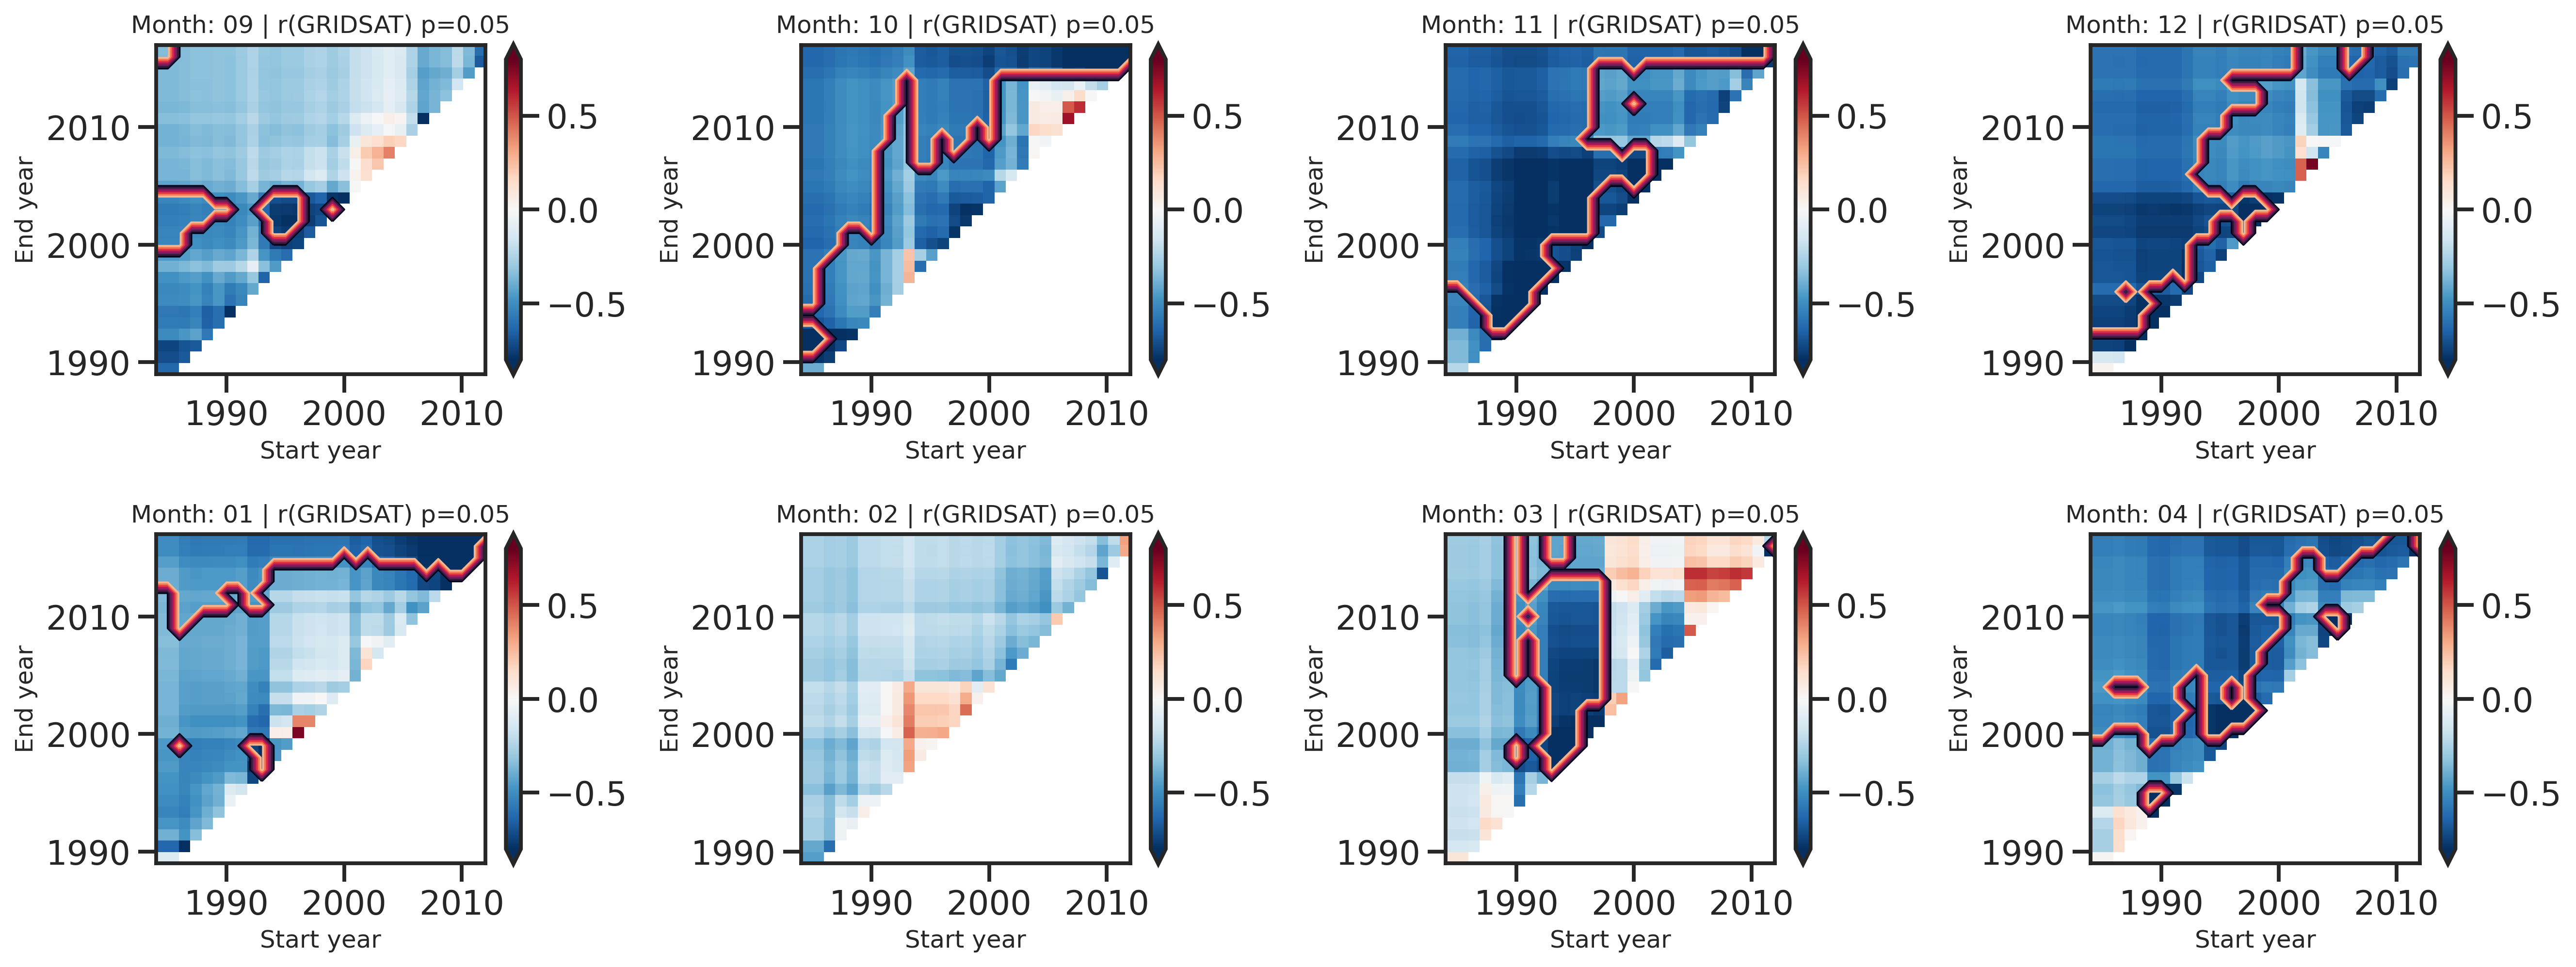

In [165]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,da3)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(GRIDSAT) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);

plt.tight_layout() 
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_GRIDSATvsU200_'+tag+'.jpg')

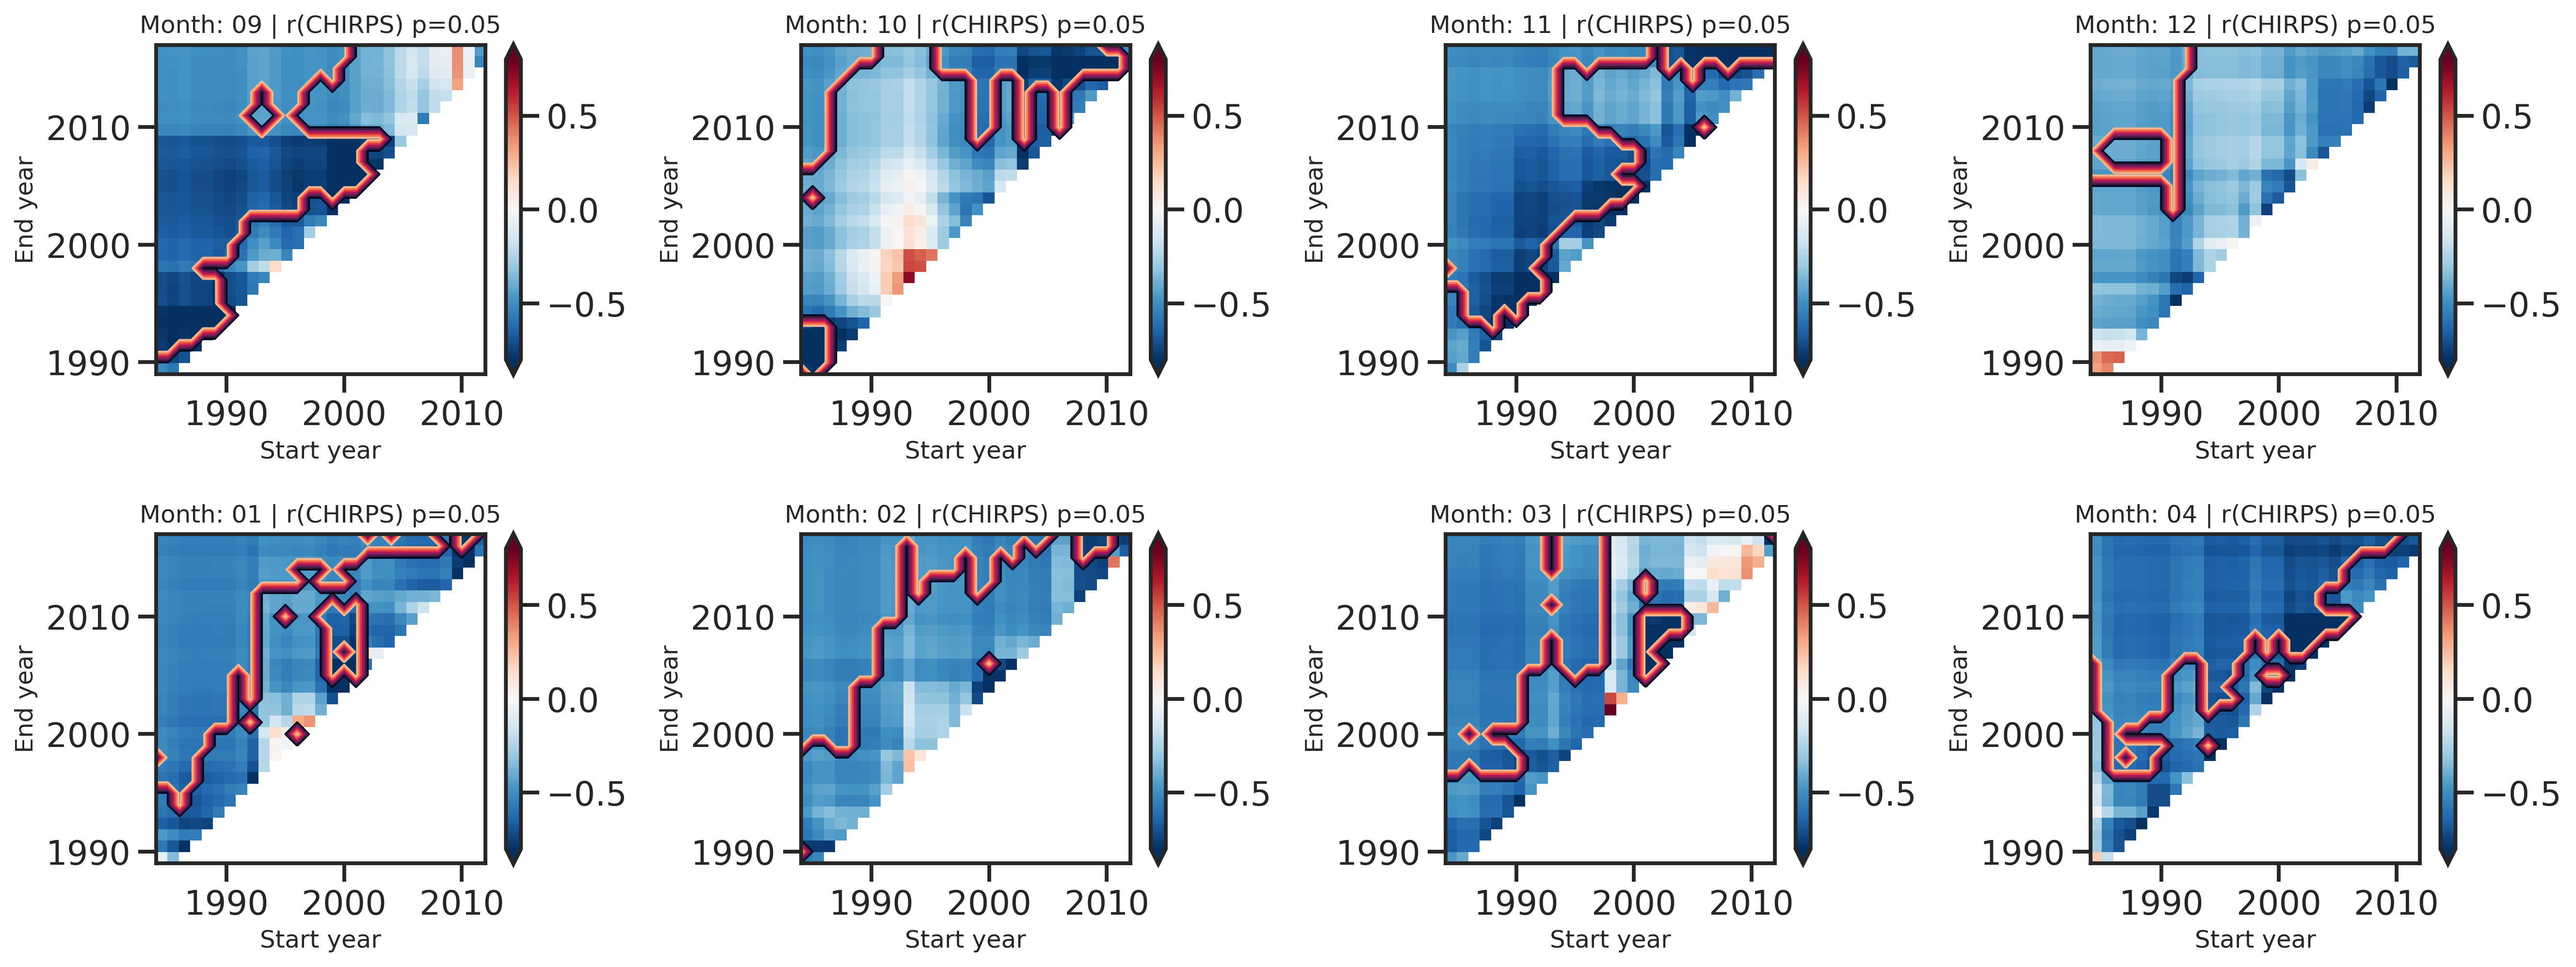

In [166]:
f = plt.figure(figsize=(18,7), dpi=300)
months = [9,10,11,12,1,2,3,4]

for ids, m in enumerate(months): 
    
    trend, sig = monthly(m, era_valley,ca)
    

    ax = f.add_subplot(2,4,ids+1)
        
    im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.8, vmax=0.8)
    plt.contour(start_years_p, end_years_p, sig < 0.05, linewidths=1)
    plt.colorbar(im, extend='both');
    plt.title('Month: '+str(m).zfill(2)+' | r(CHIRPS) p=0.05', fontsize=12);
    plt.xlabel('Start year', fontsize=12);
    plt.ylabel('End year', fontsize=12);
plt.tight_layout() 
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/triangle_monthly_CHIRPSvsU200_'+tag+'.jpg')